In [1]:
import numpy as np, json, matplotlib, pycm, pandas as pd, seaborn as sn
from datetime import datetime
from conceptual_engineering_assistant import Concept, Entity, ConceptualEngineeringAssistant
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import WikipediaLoader

In [2]:
SAMPLE_SIZE = 4
females = np.random.choice(json.load(open('data/females-2023-03-15.json', 'r')), SAMPLE_SIZE)
males = np.random.choice(json.load(open('data/males-2023-03-15.json', 'r')), SAMPLE_SIZE)
non_binaries = np.random.choice(json.load(open('data/non-binaries-2023-03-15.json', 'r')), SAMPLE_SIZE)
trans_men = np.random.choice(json.load(open('data/trans-men-2023-03-15.json', 'r')), SAMPLE_SIZE)
trans_women = np.random.choice(json.load(open('data/trans-women-2023-03-15.json', 'r')), SAMPLE_SIZE)
sample = np.concatenate((females, trans_women, non_binaries, trans_men, males))

In [3]:
for entity in sample:
    entity["description"] = WikipediaLoader(query=entity["name"], load_max_docs=1).load()[0].page_content[:1200]

In [4]:
entities = pd.DataFrame.from_records(sample)
woman_conditions = [
    ((entities.gender == 'female') | (entities.gender == 'trans woman')),
    ((entities.gender == 'non-binary') | (entities.gender == 'male') | (entities.gender == 'trans man'))
]
woman_categories = ['true', 'false']
entities['woman'] = np.select(woman_conditions, woman_categories)
entities

,item,name,article,gender,description,woman
0,http://www.wikidata.org/entity/Q51755,Ahsoka Tano,https://en.wikipedia.org/wiki/Ahsoka_Tano,female,Ahsoka Tano is a fictional character in the St...,true
1,http://www.wikidata.org/entity/Q69336,Maria of Bohemia,https://en.wikipedia.org/wiki/Maria_of_Bohemia,female,Maria Theresa (Maria Theresia Walburga Amalia ...,true
2,http://www.wikidata.org/entity/Q14439,Phoebe Cates,https://en.wikipedia.org/wiki/Phoebe_Cates,female,"Phoebe Belle Cates Kline (born July 16, 1963) ...",true
3,http://www.wikidata.org/entity/Q7485,Anna J. Harrison,https://en.wikipedia.org/wiki/Anna_J._Harrison,female,"Anna Jane Harrison (December 23, 1912 – August...",true
4,http://www.wikidata.org/entity/Q3295771,Calpernia Addams,https://en.wikipedia.org/wiki/Calpernia_Addams,trans woman,"Calpernia Sarah Addams (born February 20, 1971...",true
5,http://www.wikidata.org/entity/Q4762409,Angela Clayton,https://en.wikipedia.org/wiki/Angela_Clayton,trans woman,Angela Helen Clayton MBE (1959 – 8 January 201...,true
6,http://www.wikidata.org/entity/Q5043441,Carmen Carrera,https://en.wikipedia.org/wiki/Carmen_Carrera,trans woman,"Carmen Carrera (born April 13, 1985) is an Ame...",true
7,http://www.wikidata.org/entity/Q108762032,Elie Che,https://en.wikipedia.org/wiki/Elie_Che,trans woman,"Elie Che, also known as Elijah Che (10 April 1...",true
8,http://www.wikidata.org/entity/Q84261380,Asher Jelinsky,https://en.wikipedia.org/wiki/Asher_Jelinsky,non-binary,Asher Jelinsky is an American film director an...,false
9,http://www.wikidata.org/entity/Q24045393,Jo Zayner,https://en.wikipedia.org/wiki/Jo_Zayner,non-binary,Jo Zayner (formerly Josiah Zayner; born Februa...,false


In [5]:
oed_woman = Concept("oed_woman", "woman", "An adult female human being. The counterpart of man (see man, n.¹ II.4.)")

In [6]:
haslanger_woman = Concept("haslanger_woman", "woman", """S is a woman iff (i) S is regularly and for the most part observed or imagined to have 
certain bodily features presumed to be evidence of a female’s biological role in reproduction; 
(ii) that S has these features marks S within the dominant ideology of S’s society as someone who 
ought to occupy certain kinds of social position that are in fact subordinate (and so motivates 
and justifies S’s occupying such a position); and (iii) the fact that S satisfies (I) and (ii) plays 
a role in S’s systematic subordination, that is, along some dimension, S’s social position is oppressive, 
and S’s satisfying (i) and (ii) plays a role in that dimension of subordination""")

In [7]:
homosaurus_woman = Concept("homosaurus_woman", "woman", """Adults who self-identify as women and understand their gender in terms of Western conceptions of 
womanness, femaleness, and/or femininity. The term has typically been defined as adult female humans, though not all women identify with 
the term "female" depending on the context in which it is used.""")

In [8]:
cea = ConceptualEngineeringAssistant()

In [9]:
oed_classifications = pd.DataFrame( 
    [ cea.classify_entity(oed_woman, Entity(entity["item"], entity["name"], entity["description"])) for entity in sample ], 
    columns = [ 'entity' , 'classification', 'rationale' ] 
    )
oed_classifications["classification"] = oed_classifications["classification"].str.lower()

In [10]:
oed_results = pd.concat([entities[["name", "gender", "woman"]], oed_classifications[["classification", "rationale"]]], axis=1)
results_styler = oed_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,woman,classification,rationale
0,Ahsoka Tano,female,true,true,"The definition of a woman is an adult female human being. While Ahsoka Tano is a fictional character, she is portrayed and represented as a female character in the Star Wars franchise. She is referred to with female pronouns and has a female voice actor, Ashley Eckstein, and a female live-action actor, Rosario Dawson. Therefore, within the context of her fictional universe, Ahsoka Tano can be considered a woman."
1,Maria of Bohemia,female,true,true,"Maria of Bohemia, also known as Maria Theresa, is described as an adult female human being. She held various positions of power and was the only woman to hold the position of ruler of the Habsburg dominions in her own right. She was also referred to as a Duchess and Empress, which are titles typically given to female individuals. Therefore, based on the definition provided, Maria of Bohemia can be classified as a woman."
2,Phoebe Cates,female,true,true,"The text provides information that Phoebe Cates is an adult, as indicated by her birth date of July 16, 1963, which makes her over 18 years old. The text also refers to Phoebe Cates using female pronouns such as ""she"" and ""her"", indicating that she is female. Therefore, based on the definition of a woman as an adult female human being, we can assert that Phoebe Cates is a woman."
3,Anna J. Harrison,female,true,true,"The definition of a woman is an adult female human being. Anna J. Harrison is described as an adult human being who was a professor of chemistry and the first female president of the American Chemical Society. The use of the term ""female"" to describe her aligns with the definition of a woman. Therefore, based on the provided definition and the information about Anna J. Harrison, it can be argued that Anna J. Harrison is a woman."
4,Calpernia Addams,trans woman,true,true,"The definition of a woman is an adult female human being. Calpernia Addams is an adult human being who has identified herself as a transgender woman. This means she identifies as a female, which aligns with the definition of a woman. Therefore, based on the definition provided and the information about Calpernia Addams, it can be argued that Calpernia Addams is a woman."
5,Angela Clayton,trans woman,true,true,"The definition provided for the concept of a woman is ""an adult female human being."" Angela Clayton, as described in the provided information, is an adult human being who is referred to with female pronouns (""she"" and ""her""). Therefore, based on the provided definition and the information given about Angela Clayton, it can be asserted that Angela Clayton is a woman."
6,Carmen Carrera,trans woman,true,true,"The definition of a woman is an adult female human being. The description of Carmen Carrera states that she is a transgender woman. This means that she identifies and lives as a woman, thus fitting the definition of an adult female human being. Therefore, based on the provided definition and the information about Carmen Carrera, it can be argued that Carmen Carrera is a woman."
7,Elie Che,trans woman,true,true,"Elie Che is considered a woman based on the provided definition of a woman as an adult female human being. The description clearly states that Elie Che was a British transgender woman. This indicates that she identified and lived as a female, which aligns with the given definition of a woman. Furthermore, she was an adult, having been born in 1998 and died in 2020, making her 22 years old at the time of her death. Therefore, based on the definition and the information provided about Elie Che, it can be argued that Elie Che is a woman."
8,Asher Jelinsky,non-binary,false,false,"Based on the provided definition of a woman as an ""adult female human being,"" and the information given about Asher Jelinsky, there is no evidence to support the assertion that Asher Jelinsky is a woman. The text explicitly states that Jelinsky is non-binary and uses gender-neutr

In [11]:
haslanger_classifications = pd.DataFrame( 
    [ cea.classify_entity(haslanger_woman, Entity(entity["item"], entity["name"], entity["description"])) for entity in sample ], 
    columns = [ 'entity' , 'classification', 'rationale' ] 
    )
haslanger_classifications["classification"] = haslanger_classifications["classification"].str.lower()

In [12]:
haslanger_results = pd.concat([entities[["name", "gender", "woman"]], haslanger_classifications[["classification", "rationale"]]], axis=1)
results_styler = haslanger_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,woman,classification,rationale
0,Ahsoka Tano,female,true,true,"Based on the provided definition, Ahsoka Tano can be considered a woman. Firstly, she is observed and imagined to have certain bodily features presumed to be evidence of a female’s biological role in reproduction. This is evident from her portrayal in the Star Wars franchise where she is depicted as a female character. Secondly, within the dominant ideology of her society, she is marked as someone who ought to occupy certain kinds of social position that are in fact subordinate. This is seen in her role as a Jedi Padawan, a position that is subordinate to her master, Anakin Skywalker. Lastly, the fact that she satisfies the first two conditions plays a role in her systematic subordination. This is seen in her journey throughout the Star Wars franchise where she faces various challenges and adversities due to her position and gender. Therefore, according to the provided definition, Ahsoka Tano is a woman."
1,Maria of Bohemia,female,true,true,"Maria of Bohemia, also known as Maria Theresa, can be considered a woman based on the provided definition. Firstly, it can be inferred that Maria Theresa was observed or imagined to have certain bodily features presumed to be evidence of a female’s biological role in reproduction. This is suggested by the fact that she was the only woman to hold the position of ruler in her own right, indicating that she was recognized as female in her society. Secondly, Maria Theresa's position as a ruler in a patriarchal society marks her within the dominant ideology of her society as someone who ought to occupy certain kinds of social position that are in fact subordinate. Despite her high status, she was still subject to the societal norms and expectations of her time, which were largely patriarchal and often placed women in subordinate positions. Finally, the fact that Maria Theresa satisfies both (i) and (ii) plays a role in her systematic subordination. Despite her powerful position, she faced opposition and challenges from male counterparts such as Frederick II of Prussia, indicating that her social position was oppressive along some dimension. Therefore, based on the provided definition, Maria of Bohemia can be considered a woman."
2,Phoebe Cates,female,true,true,"Based on the provided definition, Phoebe Cates can be considered a woman. Firstly, the description does not explicitly state, but it is implied that Phoebe Cates is observed or imagined to have certain bodily features presumed to be evidence of a female’s biological role in reproduction. This is suggested by the use of female pronouns and the fact that she was a model for teen-oriented magazines, which typically feature women. Secondly, as an actress in Hollywood, she likely occupies a social position that is marked within the dominant ideology of her society as someone who ought to occupy certain kinds of social position that are in fact subordinate. This is suggested by her roles in films and the fact that Hollywood has historically been a male-dominated industry. Lastly, the fact that she satisfies both conditions (i) and (ii) likely plays a role in her systematic subordination. As an actress, she is part of an industry where women are often paid less than their male counterparts and are often subjected to objectification and sexualization. This could be seen as a form of oppression, thus satisfying condition (iii). Therefore, based on the provided definition and the information given about Phoebe Cates, it can be argued that she is a woman."
3,Anna J. Harrison,female,true,true,"Anna J. Harrison can be considered a woman based on the provided definition. Firstly, it can be inferred that she is observed or imagined to have certain bodily features presumed to be evidence of a female’s biological role in reproduction, as she is referred to with female pronouns and a traditionally female first name. Secondly, despite her significant achievements in the field of ch

In [13]:
homosaurus_classifications = pd.DataFrame( 
    [ cea.classify_entity(homosaurus_woman, Entity(entity["item"], entity["name"], entity["description"])) for entity in sample ], 
    columns = [ 'entity' , 'classification', 'rationale' ] 
    )
homosaurus_classifications["classification"] = homosaurus_classifications["classification"].str.lower()

In [14]:
homosaurus_results = pd.concat([entities[["name", "gender", "woman"]], homosaurus_classifications[["classification", "rationale"]]], axis=1)
results_styler = homosaurus_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,woman,classification,rationale
0,Ahsoka Tano,female,true,true,"Based on the provided definition of a woman, Ahsoka Tano can be considered a woman. This is because she is an adult character in the Star Wars franchise who is portrayed and understood as female. Although the term ""woman"" is not explicitly used in the description, the use of female pronouns and the fact that she is voiced and portrayed by women (Ashley Eckstein and Rosario Dawson) in various adaptations of the franchise suggest that she identifies with the term ""female"". Furthermore, her character is developed and understood in terms of Western conceptions of womanness, femaleness, and/or femininity, as evidenced by her roles and actions in the series. Therefore, based on the provided definition and the information about Ahsoka Tano, it can be argued that she is a woman."
1,Maria of Bohemia,female,true,true,"Maria of Bohemia, also known as Maria Theresa, is identified as a woman based on the provided definition. The description states that she was the only woman to hold the position of ruler of the Habsburg dominions in her own right, which indicates that she self-identifies as a woman. Furthermore, she is referred to using female pronouns such as ""she"" and ""her"", which aligns with the Western conceptions of womanness and femaleness. Additionally, her marriage and the title of Duchess of Lorraine, Grand Duchess of Tuscany and Holy Roman Empress, typically associated with women, further supports the assertion that Maria of Bohemia is a woman."
2,Phoebe Cates,female,true,true,"Phoebe Cates is identified as a woman based on the provided definition. The text refers to her using female pronouns such as ""she"" and ""her"", indicating that she identifies as a woman. Furthermore, she is an adult, fulfilling the age requirement in the definition of a woman. The text does not provide any information that would contradict her identification as a woman. Therefore, based on the information provided, it can be asserted that Phoebe Cates is a woman."
3,Anna J. Harrison,female,true,true,"Anna J. Harrison is identified as a woman based on the provided definition. The text refers to her using female pronouns such as ""she"" and ""her"", which aligns with the Western conception of womanness and femaleness. Furthermore, she is described as the ""first female president of the American Chemical Society"", which indicates that she identifies with the term ""female"". Therefore, based on the definition and the information provided about Anna J. Harrison, it can be asserted that she is a woman."
4,Calpernia Addams,trans woman,true,true,"According to the provided definition, a woman is an adult who self-identifies as a woman and understands their gender in terms of Western conceptions of womanness, femaleness, and/or femininity. The entity, Calpernia Addams, is described as having come out as a transgender woman during her last year in the military. This indicates that she self-identifies as a woman. Therefore, based on the given definition, Calpernia Addams can be classified as a woman."
5,Angela Clayton,trans woman,true,true,"The text does not provide explicit information about Angela Clayton's self-identification as a woman or her understanding of her gender in terms of Western conceptions of womanness, femaleness, and/or femininity. However, the text refers to Angela Clayton using female pronouns (""she"", ""her""), which is typically indicative of a female or woman identity in Western culture. Additionally, Angela Clayton was a campaigner for the rights of transgender people, which could suggest that she had a personal understanding or experience with gender identity issues, possibly including her own identification as a woman. Therefore, based on the information provided, one could argue that Angela Clayton is a woman."
6,Carmen Carrera,trans woman,true,true,"The definition of a woman includes adults who self-identify as women and understand their gender in terms

In [15]:
def confusion_matrix(results):
    return results[["gender", "classification"]].groupby(['gender','classification'], sort=False).size().unstack(fill_value=0)[["true", "false"]]

In [16]:
def confusion_matrix_2(results):
    return results[["woman", "classification"]].groupby(['woman','classification'], sort=False).size().unstack(fill_value=0)[["true", "false"]]

<Axes: xlabel='classification', ylabel='gender'>

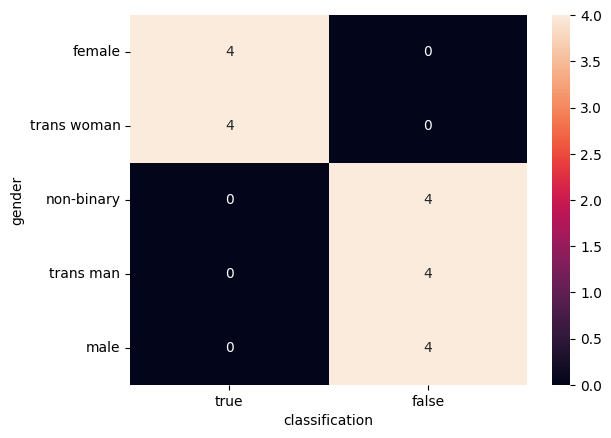

In [17]:
sn.heatmap(confusion_matrix(oed_results), annot=True)

<Axes: xlabel='classification', ylabel='woman'>

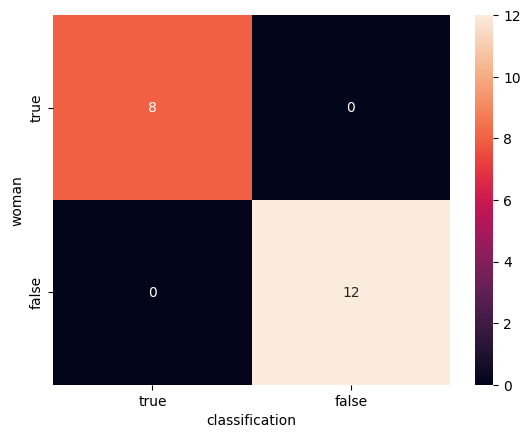

In [18]:
sn.heatmap(confusion_matrix_2(oed_results), annot=True)

In [30]:
oed_cm = pycm.ConfusionMatrix(oed_results["woman"].tolist(), oed_results["classification"].tolist(), digit=2, classes=['true', 'false'])
print(f'Accuracy: {oed_cm.overall_stat["Overall ACC"]:.2f}')
print(f'Scott\'s pi: {oed_cm.PI:.2f}')

Accuracy: 1.00
Scott's pi: 1.00


<Axes: xlabel='classification', ylabel='gender'>

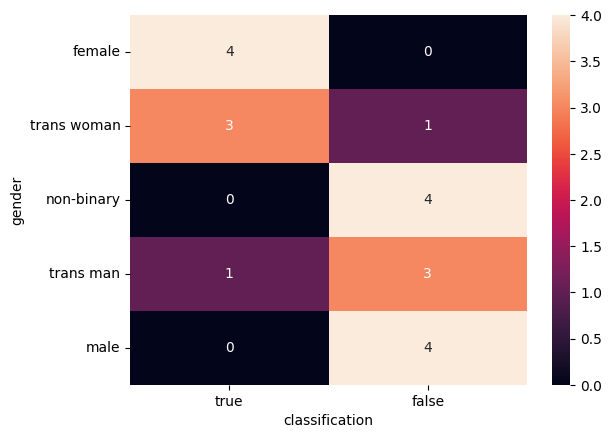

In [20]:
sn.heatmap(confusion_matrix(haslanger_results), annot=True)

<Axes: xlabel='classification', ylabel='woman'>

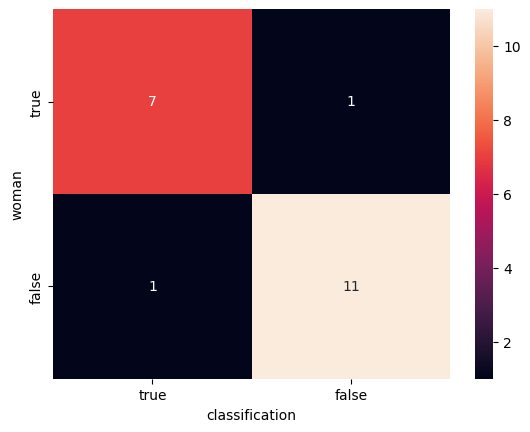

In [21]:
sn.heatmap(confusion_matrix_2(haslanger_results), annot=True)

In [28]:
haslanger_cm = pycm.ConfusionMatrix(haslanger_results["woman"].tolist(), haslanger_results["classification"].tolist(), digit=2, classes=['true', 'false'])
print(f'Accuracy: {haslanger_cm.overall_stat["Overall ACC"]:.2f}')
print(f'Scott\'s pi: {haslanger_cm.PI:.2f}')

Accuracy: 0.90
Scott's pi: 0.79


<Axes: xlabel='classification', ylabel='gender'>

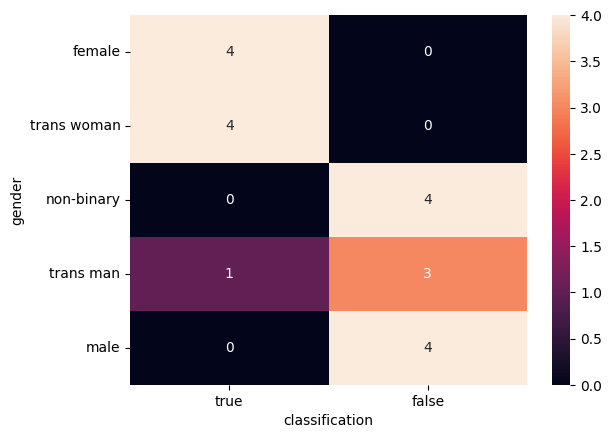

In [23]:
sn.heatmap(confusion_matrix(homosaurus_results), annot=True)

<Axes: xlabel='classification', ylabel='woman'>

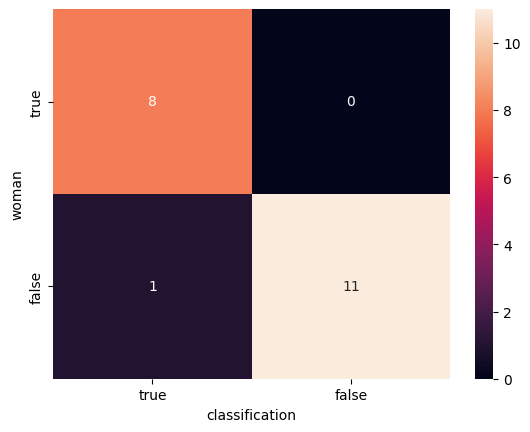

In [24]:
sn.heatmap(confusion_matrix_2(homosaurus_results), annot=True)

In [29]:
homosaurus_cm = pycm.ConfusionMatrix(homosaurus_results["woman"].tolist(), homosaurus_results["classification"].tolist(), digit=2, classes=['true', 'false'])
print(f'Accuracy: {homosaurus_cm.overall_stat["Overall ACC"]:.2f}')
print(f'Scott\'s pi: {homosaurus_cm.PI:.2f}')

Accuracy: 0.95
Scott's pi: 0.90


In [26]:
def evaluation_record(model, concept, data):
    return {
        "created": datetime.now().isoformat(),
        "model": {
            "name": cea.model_name,
            "temperature": cea.temperature,
        },
        "concept": concept.to_json(),
        "data": data.to_dict('records'),
    }

In [27]:
oed_evaluation_record = evaluation_record(cea, oed_woman, pd.concat([entities, oed_classifications], axis=1))
haslanger_evaluation_record = evaluation_record(cea, haslanger_woman, pd.concat([entities, haslanger_classifications], axis=1))
homosaurus_evaluation_record = evaluation_record(cea, homosaurus_woman, pd.concat([entities, homosaurus_classifications], axis=1))
json.dump(
    oed_evaluation_record, 
    open(f'data/{oed_evaluation_record["model"]["name"]}_{oed_evaluation_record["concept"]["id"]}_{oed_evaluation_record["created"]}.json', 'w')
)
json.dump(
    haslanger_evaluation_record, 
    open(f'data/{haslanger_evaluation_record["model"]["name"]}_{haslanger_evaluation_record["concept"]["id"]}_{haslanger_evaluation_record["created"]}.json', 'w')
)
json.dump(
    homosaurus_evaluation_record, 
    open(f'data/{homosaurus_evaluation_record["model"]["name"]}_{homosaurus_evaluation_record["concept"]["id"]}_{homosaurus_evaluation_record["created"]}.json', 'w')
)